## Data
10 tasks, 10k training examples per task.

10 epochs, learning rate $1\times 10^{-4}$, batch size = 128

### pip Installation

In [1]:
!dir

Multi_Variable_Causal_Abstraction.ipynb  sample_data.tsv
Zen_Code				 sample_data_10000.tsv
causal_abstract_env			 sample_data_100000_2.tsv
ft_model				 sample_data_10000_2.tsv
ft_model.zip				 sample_data_20000.tsv
ft_model_classifier			 sample_data_20000_2.tsv
pretrained_model			 utils.py


In [ ]:
! pip install pyvene
! pip install nnsight

Check installed package

In [ ]:
!pip list

### Set-up

In [ ]:
import torch
from torch.utils.data import DataLoader
import random
import copy
import itertools
import numpy as np
import pyvene as pv
from tqdm import tqdm, trange


from sklearn.metrics import classification_report
from transformers import get_linear_schedule_with_warmup

from pyvene import CausalModel
from pyvene.models.mlp.modelings_mlp import MLPConfig
from pyvene import create_mlp_classifier
from pyvene import (
    IntervenableModel,
    VanillaIntervention,
    RotatedSpaceIntervention,
    LowRankRotatedSpaceIntervention,
    RepresentationConfig,
    IntervenableConfig,
)

In [ ]:
seed = 516
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### The WordLogic Task
10 tasks in total. A task example:
$[(t_2=t_4)\wedge\neg(t_0=t_4)]\vee \mathtt{IS\_SYN}(t_1, t_3)$

In [5]:
from utils import fetch_metadata

input_dir = "Zen_Code/causal-tracing/data"
vocab,_,_ = fetch_metadata(input_dir)

FileNotFoundError: [Errno 2] No such file or directory: 'Zen_Code/causal-tracing/data/token_cos_synonyms.txt'

In [49]:
import pandas as pd
import numpy as np
import random
# 加载 GPT-2 词汇表
from transformers import GPT2Tokenizer
#tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
#vocab = list(tokenizer.get_vocab().keys())  # 获取所有词汇

# sampling
n_sample = 20000
random_choices = np.random.choice(vocab, size=(n_sample, 5))
random_probs = np.random.random(size=(n_sample, 3))

# Generate samples
samples = [
    (
        f"{t0},{t1},{t2},{t3},{t4}",
        ((t2 == t4) and not (t0 == t4)) or (t1 == t3)
    )
    for t0, t1, t2, t3, t4 in zip(
        random_choices[:, 0],
        np.where(random_probs[:, 0] < 0.5, random_choices[:, 0], random_choices[:, 1]),
        random_choices[:, 2],
        np.where(random_probs[:, 1] < 0.3, random_choices[:, 1], random_choices[:, 3]),
        np.where(random_probs[:, 2] < 0.5, random_choices[:, 2], random_choices[:, 4])
    )
]
# save to a file
df = pd.DataFrame(samples, columns=["texts", "labels"])
df.to_csv("sample_data_zen_20000.tsv", sep="\t", index=False)

In [ ]:
# construct the hypithesize causal model
variables = ["T0", "T1", "T2", "T3", "T4", "E", "NE", "IS_SYN", "AND", "OR"]

reps = [s[0].split(",") for s in samples]
values = {}
values["T0"] = [lst[0] for lst in reps]
values["T1"] = [lst[1] for lst in reps]
values["T2"] = [lst[2] for lst in reps]
values["T3"] = [lst[3] for lst in reps]
values["T4"] = [lst[4] for lst in reps]
values["E"] = [True, False]
values["NE"] = [True, False]
values["IS_SYN"] = [True, False]
values["AND"] = [True, False]
values["OR"] = [True, False]

parents = {
    "T0": [],
    "T1": [],
    "T2": [],
    "T3": [],
    "T4": [],
    "E": ["T2", "T4"],
    "NE": ["T0", "T4"],
    "IS_SYN": ["T1", "T3"],
    "AND": ["E", "NE"],
    "OR": ["AND", "IS_SYN"]
}

def FILLER():
    return reps[0]

# def IS_SYN(x, y):
#   return flag

functions = {
    "T0": FILLER,
    "T1": FILLER,
    "T2": FILLER,
    "T3": FILLER,
    "T4": FILLER,
    "E": lambda x, y: x == y,
    "NE": lambda x, y: x != y,
    "IS_SYN": lambda x, y: x == y,
    "AND": lambda x, y: x and y,
    "OR": lambda x, y: x or y
}

pos = {
    "T0": (0.2, 0),
    "T1": (0.8, 0),
    "T2": (1.4, 0),
    "T3": (2, 0),
    "T4": (2.6, 0),
    "E": (0.5, 1),
    "NE": (1.4, 1),
    "IS_SYN": (2.3, 1),
    "AND": (1.1, 2),
    "OR": (1.1, 3)
}

equality_model = CausalModel(variables, values, parents, functions, pos=pos)
equality_model.print_structure()

In [212]:
## Mutiple Tasks

In [214]:
import pandas as pd

# 加载 GPT-2 词汇表
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
#vocab = list(tokenizer.get_vocab().keys())  # 获取所有词汇

# Number of samples
num_samples = 10000

tasks = [
    lambda p, q, r: p and q and r,
    lambda p, q, r: not p and q and r, 
    lambda p, q, r: p and not q and r, #
    lambda p, q, r: not p and not q and r,#
    lambda p, q, r: p and q and not r,
    lambda p, q, r: not p and q and not r, 
    lambda p, q, r: p and not q and not r, 
    lambda p, q, r: not p and not q and not r,
]

samples = [] 
selected_tasks = [] 

for task_id, task in enumerate(tasks): 
  np.random.seed(task_id + 5) 
  single_task_sample =[] 
  num_true = 0 

  # Precompute random choices
  t0_choices = np.random.choice(vocab, num_samples)
  t1_choices = np.random.choice(vocab, num_samples)
  t2_choices = np.random.choice(vocab, num_samples)
  t3_choices = np.random.choice(vocab, num_samples)
  t4_choices = np.random.choice(vocab, num_samples)

  # Generate samples
  for i in range(num_samples):
      t0 = t0_choices[i]
      t1 = t0 if np.random.random() < 0.5 else t1_choices[i]
      t2 = t2_choices[i]
      t3 = t1 if np.random.random() < 0.3 else t3_choices[i]
      t4 = t2 if np.random.random() < 0.5 else t4_choices[i]
      p, q, r = (t2 == t4), (t0 == t4), (t1 == t3)
      label = task(p, q, r)
      if label: 
        num_true += 1 
      single_task_sample.append((f"{t0},{t1},{t2},{t3},{t4}", str(label))) 
  if num_true > 0.25 * num_samples and num_true < 0.75 * num_samples: 
      samples += single_task_sample
      selected_tasks.append(task_id)

print(selected_tasks)

# Save to a file
df = pd.DataFrame(samples, columns=["texts", "labels"])
df.to_csv(f"sample_data_Zen_{num_samples}_.tsv", sep="\t", index=False)

[3, 6]


## Import the GPT2 models and finetuning GPT2



In [32]:
from transformers import GPT2LMHeadModel, AutoModelForCausalLM, GPT2Tokenizer, Trainer, TrainingArguments, DataCollatorForLanguageModeling, EarlyStoppingCallback
import torch
from tqdm.auto import tqdm
from torch.utils.data import Dataset, random_split
from sklearn.model_selection import train_test_split
import os
import random
import pandas as pd

The following is the code to finetune GPT2.
1. Load the model

In [33]:
# Load model and tokenizer
model_path_ft = "./ft_model/fine_tuned_gpt2"
if os.path.exists(model_path_ft):
  print(f"Loading existing model from {model_path_ft}")
  model = GPT2LMHeadModel.from_pretrained(model_path_ft)
  tokenizer = GPT2Tokenizer.from_pretrained(model_path_ft)
  print("Model loaded successfully!")
elif os.path.exists("./pretrained_model/pretrained_tuned_gpt2"):
  print(f"Loading existing model from ./pretrained_model/pretrained_tuned_gpt2")
  model = GPT2LMHeadModel.from_pretrained("./pretrained_model/pretrained_tuned_gpt2")
  tokenizer = GPT2Tokenizer.from_pretrained("./pretrained_model/pretrained_tuned_gpt2")
  print("Model loaded successfully!")
else:
  print(f"Did not find existing model from {model_path_ft}")
  print("Loading a new model from hugging face")
  model = GPT2LMHeadModel.from_pretrained('gpt2')
  tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
  tokenizer.pad_token = tokenizer.eos_token
  model.config.pad_token_id = model.config.eos_token_id
  print("Model loaded successfully!")
  # Save the model
  os.mkdir("./pretrained_model/")
  model.save_pretrained("./pretrained_model/pretrained_tuned_gpt2")
  tokenizer.save_pretrained("./pretrained_model/pretrained_tuned_gpt2")

Loading existing model from ./ft_model/fine_tuned_gpt2
Model loaded successfully!


Prepare the dataset class

In [34]:
class WordLogicDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length):
        # Tokenize with padding and truncation
        self.encodings = tokenizer(texts,
                                 truncation=True,
                                 padding=True,
                                 max_length=max_length,
                                 return_tensors="pt")
        self.texts = texts

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = item['input_ids']
        item['text'] = self.texts[idx]  # Store the original text for comparison
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

Prepare the data

In [35]:
def formattext(texts, label, context_texts, context_label, context_len):
    context_len =  min(context_len, len(context_texts))
    # pick context_len number of context_texts randomly
    formatted_texts = [f"{text}={label}" for text, label in zip(texts, label)]
    formatted_context_texts = [f"{text}={label}" for text, label in zip(context_texts, context_label)]
    for i, text in enumerate(formatted_texts):
        context_texts = random.sample(formatted_context_texts, context_len)
        context_text = "\n".join(context_texts)
        formatted_texts[i] = f"{context_text}\n{text}"
    return formatted_texts

In [41]:
# Prepare the data
# texts = ["EGA,Duration,for,reportprint,for", "Similar,agency,Examples,drm,Similar", "SPONSORED,foundland,eways,reportprint,SPONSORED", "Colorado,oreAnd,ophe,Timer,esting", "Warren,puter,ActionCode,Hol,Warren", "iffs,omics,Cas,omic,adobe"]
# labels = [1, 0, 1, 1, 0, 1]  # Your labels
df = pd.read_csv("./data/sample_data_zen_10000_0311.tsv", sep="\t")
#df_train = pd.read_csv("sample_data_Zen_10000_2.tsv", sep="\t")
texts = df["texts"].tolist()
labels = [str(label) for label in df["labels"].tolist()]

nums_contexts = 100
num_task = 1
size_per_task = len(texts) // num_task
format_texts = []
for i in range(num_task):
    context_texts = texts[size_per_task * i: size_per_task * i + nums_contexts] #df_train["texts"].tolist()[size_per_task * i: size_per_task * i + nums_contexts] # 
    context_labels =  labels[size_per_task * i: size_per_task * (i) + nums_contexts] # df_train["labels"].tolist()[size_per_task * i: size_per_task * i + nums_contexts] #
    format_texts += formattext(texts[size_per_task * (i) + nums_contexts: size_per_task *(i+1)], labels[size_per_task * (i) + nums_contexts: size_per_task *(i+1)], context_texts, context_labels, 5)

max_length = 100
# First split: separate test set (80% train+val, 20% test)
train_val_texts, test_texts = train_test_split(
    format_texts, test_size=0.2, random_state=35
)

# Second split: separate train and validation from the remaining 80%
train_texts, val_texts = train_test_split(
    train_val_texts, test_size=0.25, random_state=42  # 0.25 of 80% = 20% of total
)

# Create datasets
train_dataset = WordLogicDataset(train_texts, tokenizer, max_length=max_length)
val_dataset = WordLogicDataset(val_texts, tokenizer, max_length=max_length)
test_dataset = WordLogicDataset(test_texts, tokenizer, max_length=max_length)


In [42]:
print(test_texts[0])
print(size_per_task)
#print(test_texts[len(test_texts) // num_task])

riers,Ren,etts,ipper,Scient,avour=True
Aside,associated,Template,associated,Third,Aside=False
purpose,sch,killer,swick,itudes,purpose=False
also,UNCH,mag,UNCH,mag,opping=True
technical,Rock,lines,Rock,undred,lander=True
oyd,act,Psy,Eric,Psy,oyd=False
10000


In [43]:
print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of validation examples: {len(val_dataset)}")
print(f"Number of test examples: {len(test_dataset)}")
print(f"Number of context examples: {len(context_texts)}")

Number of training examples: 5940
Number of validation examples: 1980
Number of test examples: 1980
Number of context examples: 100


Training parameters

In [ ]:
# Check if CUDA is available
gpu_id = 0
device = f'cuda:{gpu_id}' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
model.to(device)
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, 
    mlm=False
)
# Define training arguments
training_args = TrainingArguments(
    output_dir='./ft_model/results',
    dataloader_num_workers=10,
    num_train_epochs= 50,
    per_device_train_batch_size= 128,  # REMEMBER TO CAHNGE THIS WHEN TRAINING on GPU
    per_device_eval_batch_size= 128,
    learning_rate=1e-4,
    warmup_steps = 500,
    weight_decay = 0.01,
    logging_dir='./ft_model/logs',
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",        # Save at the end of each epoch
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="loss",
    save_total_limit=2,
)

Using device: cuda


/home/jytan12/.local/lib/python3.10/site-packages/transformers/training_args.py:1609: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def training_step(self, model, inputs, return_loss=True):
        """Override training step to display loss in progress bar"""
        outputs = super().training_step(model, inputs, return_loss)
        if hasattr(self, 'progress_bar'):
            # outputs is the loss tensor directly
            self.progress_bar.set_postfix({'loss': outputs.item()})
        return outputs

    def train(self, resume_from_checkpoint=None, **kwargs):
        """Override train to add progress bar"""
        # Calculate total steps
        num_update_steps_per_epoch = len(self.train_dataset) // self.args.per_device_train_batch_size
        total_train_steps = num_update_steps_per_epoch * self.args.num_train_epochs

        # Create progress bar
        self.progress_bar = tqdm(
            total=total_train_steps,
            desc="Training",
            position=0,
            leave=True
        )

        # Train
        result = super().train(resume_from_checkpoint=resume_from_checkpoint, **kwargs)

        # Close progress bar
        self.progress_bar.close()
        return result

    def evaluation_loop(self, dataloader, description, prediction_loss_only, ignore_keys=None, metric_key_prefix="eval"):
        """Override evaluation loop to add progress bar"""
        eval_bar = tqdm(
            total=len(dataloader),
            desc=description,
            position=0,
            leave=True
        )

        output = super().evaluation_loop(
            dataloader,
            description,
            prediction_loss_only,
            ignore_keys,
            metric_key_prefix
        )
        eval_bar.close()
        return output

In [14]:
def sft(model, training_args, train_dataset, val_dataset):
  # Create Trainer
  trainer = CustomTrainer(
      model=model,
      args=training_args,
      train_dataset= train_dataset,
      data_collator=data_collator,
      eval_dataset=val_dataset,
      #callbacks=[EarlyStoppingCallback(early_stopping_patience=4)]  # early stopping callback
  )

  # Train the model
  trainer.train()

In [ ]:
sft(model, training_args, train_dataset, val_dataset)

For prediction given a sentence

In [18]:
# For inference
def predict(text, model, tokenizer, device):
    text = text.rsplit('=', 1)
    inputs = tokenizer(text[0] + '=', return_tensors="pt").to(device)
    outputs = model.generate(
        inputs['input_ids'],
        max_length=len(inputs['input_ids'][0]) + 2,  # Just enough to generate the label. Two tokens include the label and EOS
        pad_token_id=tokenizer.eos_token_id,
        num_return_sequences=1
    )

    predicted_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    #print(predicted_text)
    return predicted_text.rsplit('=',1)[1].rstrip()

In [19]:
def evaluate_model(model, test_texts, tokenizer, device):
    model.eval()
    total_correct = 0
    total_samples = len(test_texts)
    for i in range(total_samples):
        label = predict(test_texts[i], model, tokenizer, device)
        correct_label = test_texts[i].rsplit('=',1)[1]
        #print(len(label), len(correct_label))
        #print(f"{i} sample: predict {label}, correct: {correct_label}")
        if correct_label in label:
            total_correct += 1
        # else:
        #     print(f"Wrong answer! Predict: {label} correct: {correct_label}")
    
    accuracy = total_correct / total_samples
    return accuracy

In [20]:
print(test_texts[0])

leton,IED,Questions,sweet,cover=False
keleton,ute,Educ,emort,iamond=False
idges,idges,Someone,FBI,Certain=False
finding,AFTA,slow,cards,adish=False
Pref,Pref,Maria,Pref,ried=True
uran,uran,ALSE,different,ALSE=False
irting,amph,Vict,adoes,Crew=False
Sup,Sup,SOURCE,Sup,Picture=True
dam,dam,back,dam,back=False
Bank,Bank,lio,dis,them=False
ÃŃ,Ġmaker,)|,Ġfederation,)|=False


In [25]:
print("Starting evaluation...")
results = evaluate_model(model, test_texts, tokenizer, device)
# Print results

Starting evaluation...


In [26]:
print(f"Test Accuracy: {results:.4f}")

Test Accuracy: 0.9114


In [236]:
# Save the model
model.save_pretrained("./ft_model/fine_tuned_gpt2")
tokenizer.save_pretrained("./ft_model/fine_tuned_gpt2")

('./ft_model/fine_tuned_gpt2/tokenizer_config.json',
 './ft_model/fine_tuned_gpt2/special_tokens_map.json',
 './ft_model/fine_tuned_gpt2/vocab.json',
 './ft_model/fine_tuned_gpt2/merges.txt',
 './ft_model/fine_tuned_gpt2/added_tokens.json')

In [1]:
!zip -r ft_model.zip ft_model/fine_tuned_gpt2

  adding: ft_model/fine_tuned_gpt2/ (stored 0%)
  adding: ft_model/fine_tuned_gpt2/generation_config.json (deflated 24%)
  adding: ft_model/fine_tuned_gpt2/tokenizer_config.json (deflated 56%)
  adding: ft_model/fine_tuned_gpt2/merges.txt (deflated 53%)
  adding: ft_model/fine_tuned_gpt2/vocab.json (deflated 68%)
  adding: ft_model/fine_tuned_gpt2/special_tokens_map.json (deflated 80%)
  adding: ft_model/fine_tuned_gpt2/config.json (deflated 52%)
  adding: ft_model/fine_tuned_gpt2/model.safetensors (deflated 7%)


In [118]:
torch.cuda.empty_cache()

## Calculate IIA for Single node Alignment

In the following code, we align each node in the causal graph with a transformer layer in GPT2 using pyvene package. First, we need to build a causal model for the conjectured causal graph. 

In [1]:
import pyvene as pv
import random 
import numpy as np
import pandas as pd
from tqdm import tqdm, trange

from pyvene import CausalModel
from pyvene import embed_to_distrib, top_vals, format_token
from pyvene import (
    IntervenableModel,
    VanillaIntervention,
    RotatedSpaceIntervention,
    LowRankRotatedSpaceIntervention,
    RepresentationConfig,
    IntervenableConfig,
)
from contextlib import redirect_stdout
import io

In [ ]:
vocab = pd.read_csv("vocab.csv", header=None)
vocab = vocab.iloc[:, 1].tolist()

Florida


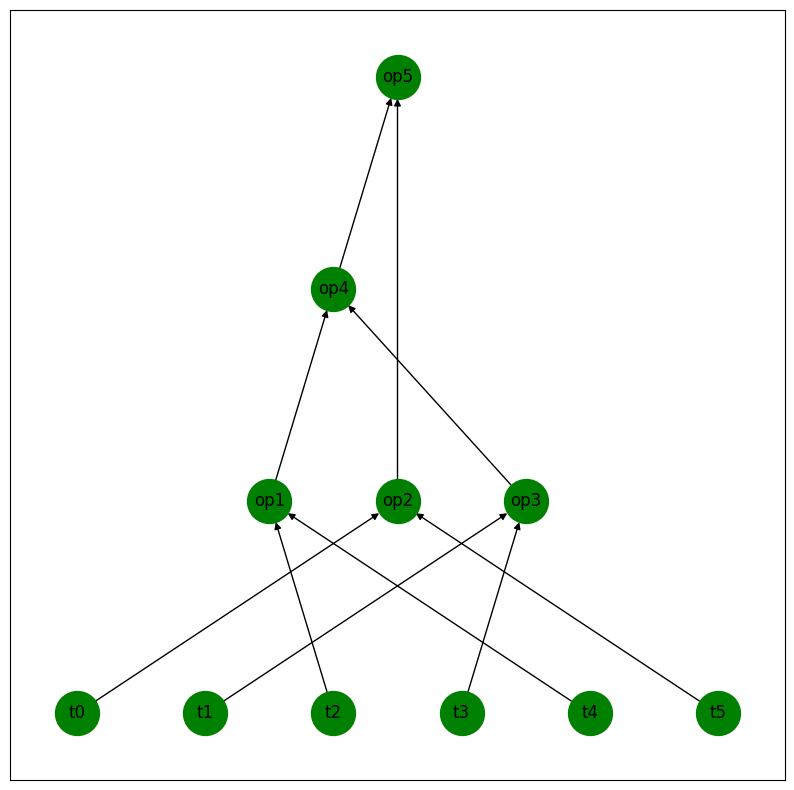

In [28]:
def randvec(n=50, lower=-1, upper=1):
    return np.array([round(random.uniform(lower, upper), 2) for i in range(n)])


variables = ["t0", "t1", "t2", "t3", "t4", "t5", "op1", "op2", "op3", "op4", "op5"]

reps = vocab
values = {variable: reps for variable in ["t0", "t1", "t2", "t3", "t4", "t5"]}
values["op1"] = [True, False]
values["op2"] = [True, False]
values["op3"] = [True, False]
values["op4"] = [True, False]
values["op5"] = [True, False]

parents = {
    "t0": [],
    "t1": [],
    "t2": [],
    "t3": [],
    "t4": [],
    "t5": [],
    "op1": ["t2", "t4"],
    "op2": ["t0", "t5"],
    "op3": ["t1", "t3"],
    "op4": ["op1", "op3"],
    "op5": ["op2", "op4"],
}


def FILLER():
    return reps[0]


functions = {
    "t0": FILLER,
    "t1": FILLER,
    "t2": FILLER,
    "t3": FILLER,
    "t4": FILLER,
    "t5": FILLER,
    "op1": lambda x, y:  x != y,
    "op2": lambda x, y:  x != y,
    "op3": lambda x, y: x == y,
    "op4": lambda x, y: x and y,
    "op5": lambda x, y: x or y,
}

pos = {
    "t0": (.1,0),
    "t1": (.3,0),
    "t2": (.5,0),
    "t3": (.7,0),
    "t4": (.9,0),
    "t5": (1.1,0),
    "op1": (.4,1),
    "op2": (.6,1),
    "op3": (.8,1),
    "op4": (.5,2),
    "op5": (.6,3)
}

equiv_classes = {}

equality_model = CausalModel(variables, values, parents, functions, pos=pos)
equality_model.print_structure()

In [20]:
def intervention_id(intervention):
    if "op1" in intervention:
        return 1
    if "op2" in intervention:
        return 2
    if "op3" in intervention:
        return 3
    if "op4" in intervention:
        return 4
    if "op5" in intervention:
        return 5
    return 0

def input_sampler(output_var = None, output_var_value = None):
    fun = lambda p, q, r: not p and not q and r
    global vocab
    # sample t0, t1, t2, t3, t4
    t0 = random.choice(vocab)
    t4 = t0 if random.random() < 0.5 else random.choice(vocab)
    t1 = random.choice(vocab)
    t3 = t1 if random.random() < 0.5 else random.choice(vocab)
    # t2 =  random.choice(vocab)
    # t4 = t2 if random.random() < 0.5 else random.choice(vocab)
    
    t2 = t4 if random.random() < 0.5 else random.choice(vocab)

    #p, q, r = (t2 != t4), (t0 != t4), (t1 == t3)

    input = {
        "t0": t0,
        "t1": t1,
        "t2": t2,
        "t3": t3,
        "t4": t4
    }
    return input


def intervention_sampler(interv: str):
    return {interv: random.choice([True, False])}


In [21]:
# Configuration for the representation model
def simple_position_config(model_type, component, layer):
    config = IntervenableConfig(
        model_type=model_type,
        representations=[
            RepresentationConfig(
                layer,              # layer
                component,          # component
                "pos",              # intervention unit
                1,                  # max number of unit
            ),
        ],
        intervention_types=VanillaIntervention,
    )
    return config

In [97]:
# Exchange intervention
def exchange_intervention(intervenable, base, sources, labels, pos):
    _, counterfactual_output = intervenable(
        base, sources, {"sources->base":pos}
    )
    ans = counterfactual_output.logits[:, -1, :].argmax(dim=-1)
    ans = [tokenizer.decode(ans_id) for ans_id in ans]
    #print(f"The answer is {ans}. The correct answer is {label}")
    count = 0
    for i in range(len(labels)):
        if ans[i] == labels[i]:
            count += 1
    return count

In [23]:
# Process input 
def format_input(raw_input, context_texts, context_labels):
    input = ",".join([raw_input["t0"], raw_input["t1"], raw_input["t2"], raw_input["t3"], raw_input["t4"]])
    contexts = ""
    for i in range(len(context_texts)):
        ##print(context)
        contexts += f"{context_texts[i]}={str(context_labels[i])}\n"
    return contexts + input + "="

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
model = model.to(device)


Using device: cuda


In [24]:
# filter dataset
def data_filter(causal_model, model, tokenizer, dataset, device, batch_size = 16):
    new_dataset = []

    for i in range(0, len(dataset), batch_size):
        batch = dataset[i : i + batch_size]

        # Prepare all base inputs
        base_texts = [
            format_input(dp["input_ids"], dp["context_texts"], dp["context_labels"])
            for dp in batch
        ]
        if len(base_texts) == 0:
            continue

        # Tokenize base inputs at once
        base_tokenized = tokenizer(
            base_texts,
            return_tensors="pt",
        ).to(device)

        # Forward pass for the entire batch
        base_outputs = model(base_tokenized["input_ids"], return_dict=True)
        # Get the last token predictions for each item in the batch
        base_logits = base_outputs.logits[:, -1, :]
        base_ids = base_logits.argmax(dim=-1)
        base_decoded = [tokenizer.decode(idx) for idx in base_ids]

        # Prepare all source inputs
        source_texts = [
            format_input(dp["source_input_ids"][0], dp["context_texts_source"], dp["context_labels_source"])
            for dp in batch
        ]
        source_tokenized = tokenizer(
            source_texts,
            return_tensors="pt"
        ).to(device)

        # Forward pass for source
        source_outputs = model(source_tokenized["input_ids"], return_dict=True)
        source_logits = source_outputs.logits[:, -1, :]
        source_ids = source_logits.argmax(dim=-1)
        source_decoded = [tokenizer.decode(idx) for idx in source_ids]

        # Compare outputs with labels
        for dp, b_out, s_out in zip(batch, base_decoded, source_decoded):
            base_label = str(dp["base_labels"]["op5"])
            source_label = str(causal_model.run_forward(dp["source_input_ids"][0])["op5"])
            if b_out == base_label and s_out == source_label:
                # Keep only valid data points
                new_dataset.append(dp)
    
    return new_dataset

In [14]:
# data_size = 10
# batch_size = 1
# interv = "op1"
# dataset = equality_model.generate_counterfactual_dataset(
#         data_size,
#         intervention_id,
#         batch_size,
#         sampler=input_sampler,
#         intervention_sampler = lambda: intervention_sampler(interv),
#         return_tensors=False,
# )
# print(dataset[0].keys())
# print( equality_model.run_forward(dataset[0]["source_input_ids"][0])["op5"])

In [29]:
def make_counterfactual_dataset(causal_model, intervention:str, samplesize:int):
    global vocab
    dataset = []

    for _ in range(samplesize):
        # sample t0, t1, t2, t3, t4 such that only intervention is False
        t0 = random.choice(vocab) 
        t5 = t0 if random.random() < 0.5 else random.choice(vocab)
        t1 = random.choice(vocab)
        t3 = t1 if random.random() < 0.5 else random.choice(vocab)
        t4 = random.choice(vocab)
        t2 = t4 if random.random() < 0.5 else random.choice(vocab)
        
        # if intervention == "op1":
        #     t2 = t4 if random.random() < 0.5 else random.choice(vocab)
        # if intervention == "op2":
        #     t0 = t4 if random.random() < 0.5 else random.choice(vocab)
        # if intervention == "op3":
        #     t1 = random.choice(vocab) if random.random() < 0.5 else t3
        # if intervention == "op4":
        #     t0 = t4 if random.random() < 0.5 else random.choice(vocab)
        #     t2 = t4 if random.random() < 0.5 else random.choice(vocab)
        # if intervention == "op5":
        #     t0 = t4 if random.random() < 0.5 else random.choice(vocab)
        #     t2 = t4 if random.random() < 0.5 else random.choice(vocab)
        #     t1 = random.choice(vocab) if random.random() < 0.5 else t3
    
        p, q, r = (t2 != t4), (t0 != t5), (t1 == t3)
    
        base_id = {
            "t0": t0,
            "t1": t1,
            "t2": t2,
            "t3": t3,
            "t4": t4,
            "t5": t5
        }
        dp = {"input_ids": base_id}
        dp["base_labels"] = {"op1": p, "op2": q, "op3": r, "op4": p and q, "op5": (p and q) or r}
        
        
        t0s = random.choice(vocab) 
        t5s = t0s if random.random() < 0.5 else random.choice(vocab)
        t1s = random.choice(vocab)
        t3s = t1s if random.random() < 0.5 else random.choice(vocab)
        t4s = random.choice(vocab)
        t2s = t4s if random.random() < 0.5 else random.choice(vocab)

        # t0s, t1s, t2s, t3s, t4s = t0, t1, t2, t3, t4
        
        if intervention == "op1" and random.random() < 0.5:
            t2s = t4s if t2 != t4 else random.choice(vocab)
        if intervention == "op2" and random.random() < 0.5:
            t0s = t5s if t0 != t4 else random.choice(vocab)
        if intervention == "op3" and random.random() < 0.5:
            t1s = t3s if t1 != t3 else random.choice(vocab)
        if intervention == "op4" and random.random() < 0.5:
            t0s, t2s = random.choice(vocab), random.choice(vocab)
        if intervention == "op5" and random.random() < 0.5:
            t4s, t5s = random.choice(vocab), random.choice(vocab)
            t1s = t3s if t1 != t3 else random.choice(vocab)

        source_id = {
            "t0": t0s,
            "t1": t1s,
            "t2": t2s,
            "t3": t3s,
            "t4": t4s,
            "t5": t5s
        }

        ps, qs, rs = (t2s != t4s), (t0s != t5s), (t1s == t3s)
        dp["source_input_ids"] = [source_id]
        dp["source_labels"] = [{"op1": ps, "op2": qs, "op3": rs, "op4": ps and qs, "op5": (ps and qs) or rs}]
        base_id[intervention] =  dp["source_labels"][0][intervention]
        dp["labels"] = causal_model.run_forward(base_id)
        #print(f"Base: {base_id} label: {p and q and r}, \nsource: {source_id}, label: {ps and qs and rs}\nlabel after interchange: {dp["labels"]}")
        dataset.append(dp)
    return dataset

In [27]:
# Check the blance of data set 
for interv in ["op1", "op2", "op3", "op4", "op5"]:
    dataset =  make_counterfactual_dataset(equality_model, interv, 1000)
    prop = 0
    for dp in dataset:
        indices = random.sample(range(len(texts)), 5)
        dp["context_texts"] = [texts[j] for j in indices]
        dp["context_labels"] = [labels[j] for j in indices]
        indices = random.sample(range(len(texts)), 5)
        dp["context_texts_source"] = [texts[j] for j in indices]
        dp["context_labels_source"] = [labels[j] for j in indices]
    #dataset = data_filter(equality_model, model, tokenizer, dataset, device)
    for dp in dataset:
        if dp["source_labels"][0]["op5"] != dp["labels"]["op5"]:
            prop += 1
    prop = prop / len(dataset)
    print(f"The dataset of intervention {interv} has {prop} of different labels")
        

The dataset of intervention op1 has 1.0 of different labels
The dataset of intervention op2 has 0.999 of different labels
The dataset of intervention op3 has 1.0 of different labels
The dataset of intervention op4 has 1.0 of different labels
The dataset of intervention op5 has 0.0 of different labels


In [ ]:
# Generate dataset
data_size = 10000
interv = "op1"
dataset = make_counterfactual_dataset(equality_model, interv, data_size)
texts = [",".join([str(dp["input_ids"][var]) for var in ["t0", "t1", "t2", "t3", "t4","t5"]]) for dp in dataset]
labels = [str(dp["labels"]["op5"]) for dp in dataset]
# count the number of true labels
# num_true = 0
# for label in labels:
#     if label == "True":
#         num_true += 1
print(f"The number of true labels is {num_true}")
df = pd.DataFrame({"texts": texts, "labels": labels})
df.to_csv(f"./data/sample_data_zen_{data_size}_0311.tsv", sep="\t", index=False)

The number of true labels is 6271


In [ ]:
#device = 'cpu'
data_size = 1024
batch_size = 32
df = pd.read_csv("./data/sample_data_zen_10000_2.tsv", sep="\t")
labels = [str(label) for label in df["labels"].tolist()]
texts = df["texts"].tolist()

data = []
for interv in ["op1", "op2", "op3", "op4", "op5"]:
    # dataset = equality_model.generate_counterfactual_dataset(
    #     data_size,
    #     intervention_id,
    #     batch_size,
    #     sampler=input_sampler,
    #     intervention_sampler = lambda: intervention_sampler(interv),
    #     return_tensors=False,
    # )
    dataset =  make_counterfactual_dataset(equality_model, interv, data_size)
    for dp in dataset:
        indices = random.sample(range(len(texts)), 5)
        dp["context_texts"] = [texts[j] for j in indices]
        dp["context_labels"] = [labels[j] for j in indices]
        indices = random.sample(range(len(texts)), 5)
        dp["context_texts_source"] = [texts[j] for j in indices]
        dp["context_labels_source"] = [labels[j] for j in indices]
    dataset = data_filter(equality_model, model, tokenizer, dataset, device)
    print(f"The sample size of dataset is {len(dataset)}, batch size {batch_size}")
    for layer in range(model.config.n_layer):
        config = simple_position_config(model, "block_output", layer)
        intervenable = IntervenableModel(config, model)
        for pos in range(66, 70):
            acc = 0
            for i in range(0, len(dataset), batch_size):
                #print(dp['source_input_ids'])
                # random sample 5 indices
                batch = dataset[i : min(i + batch_size, len(dataset))]
                base_texts = [
                format_input(dp["input_ids"], dp["context_texts"], dp["context_labels"])
                for dp in batch
                ]
                # sources = [format_input(dp["source_input_ids"][i], dp["context_texts_source"], dp["context_labels_source"]) for i in range(len(dp["source_input_ids"])) if len(dp["source_input_ids"][i])> 0]
                
                base = tokenizer(base_texts, return_tensors="pt").to(device)
                # sources = [tokenizer(source, return_tensors="pt").to(device) for source in sources]
                
                flattened_sources = []
                dp_source_counts = []
                all_labels = []
                for dp in batch:
                    # Gather all sources for this dp
                    dp_srcs = [
                        format_input(src, dp["context_texts_source"], dp["context_labels_source"])
                        for src in dp["source_input_ids"] if len(src)> 0
                    ]
                    flattened_sources.extend(dp_srcs)
                    dp_source_counts.append(len(dp_srcs))
                    all_labels.append(str(dp["labels"]["op5"]))

                
                if flattened_sources:
                    source_tokenized = tokenizer(
                        flattened_sources,
                        return_tensors="pt",
                    ).to(device)
                else:
                    source_tokenized = None
                    
                acc += exchange_intervention(intervenable, base, source_tokenized, all_labels, pos)


            acc /= len(dataset)
            data.append(
                {
                    "layer": f"{layer}",
                    "pos": pos,
                    "type": "block_output",
                    "intervention": interv,
                    "accuracy": acc
                }
            )

The sample size of dataset is 899, batch size 32
Intervention key: layer_0_comp_block_output_unit_pos_nunit_1#0
Intervention key: layer_1_comp_block_output_unit_pos_nunit_1#0
Intervention key: layer_2_comp_block_output_unit_pos_nunit_1#0


In [100]:
import json
# Save data 
with open('intervention_data_5op_t0t2_0310_1000.json', 'w') as f:
    json.dump(data, f, indent=4)

In [53]:
with open('intervention_data_5op_0310_1000.json', 'r') as f:
    data = json.load(f)

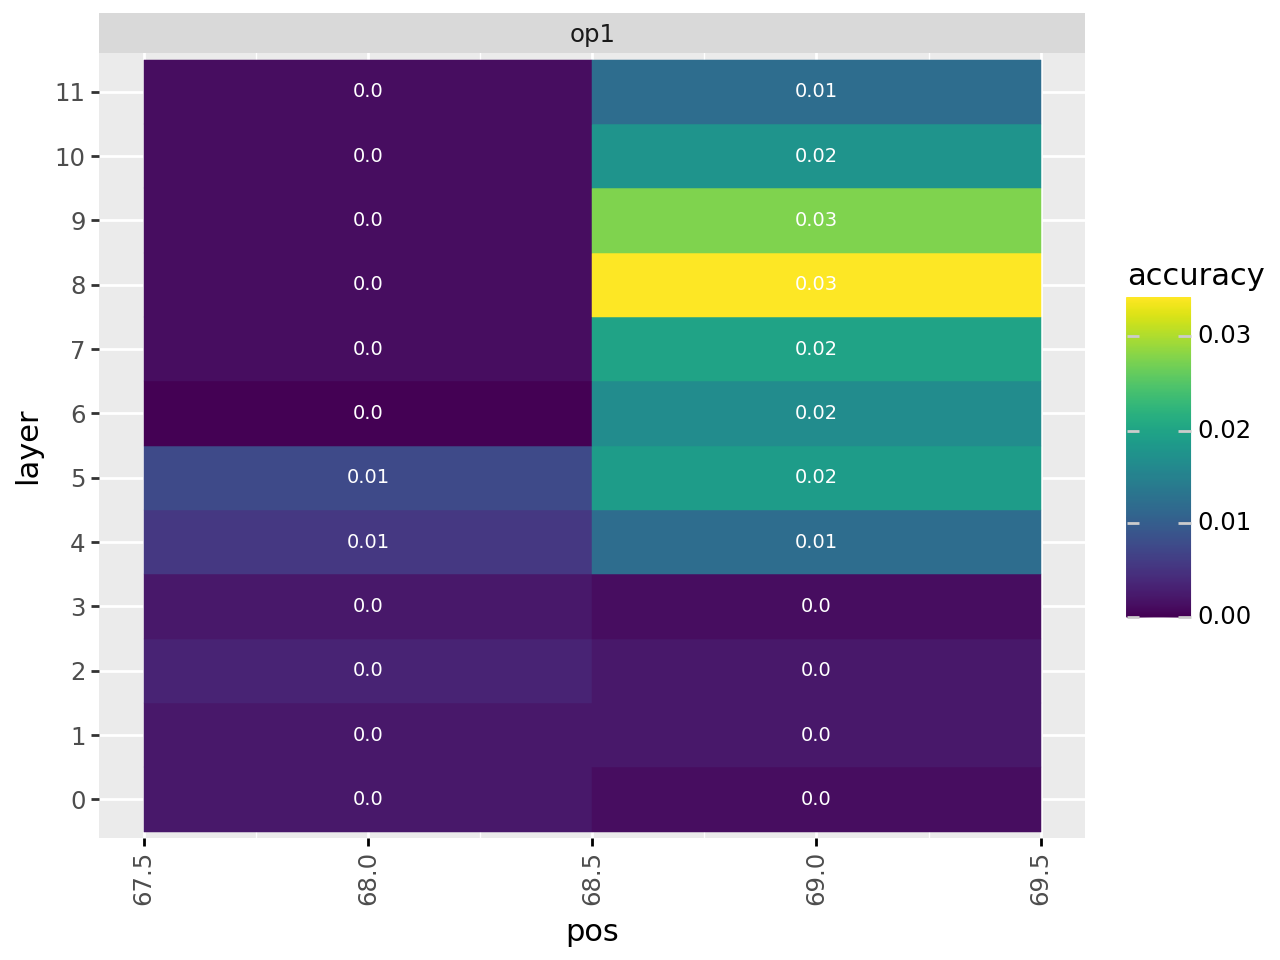

In [31]:
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    facet_wrap,
    theme,
    geom_text,
    element_text,
    geom_bar,
    geom_hline,
    scale_y_log10,
    scale_x_discrete
)


# Plot the results
df = pd.DataFrame(data)
df["layer"] = df["layer"].astype("category")
df["intervention"] = df["intervention"].astype("category")
nodes = []
for l in range(model.config.n_layer - 1, -1, -1):
    nodes.append(f"{l}")
df["layer"] = pd.Categorical(df["layer"], categories=nodes[::-1], ordered=True)
g = (
    ggplot(df)
    + geom_tile(aes(x="pos", y="layer", fill="accuracy", color="accuracy"))
    + geom_text(aes(x="pos", y="layer", label=df["accuracy"].round(2)),color="white",size = 7)  # Add text labels
    + facet_wrap("~intervention")
    + theme(axis_text_x=element_text(rotation=90))
)
g.show()